# DeepSom: Cluster Visualization using Bokeh 
### Notebook 3

#### By TJ Cycyota
##### Thanks to [thykhuely](https://www.kaggle.com/thykhuely/mercari-interactive-eda-topic-modelling) on Kaggle for inspiration

### Hypothesis
We can visualize wine clusters using multiple dimensionality-reduction techniques, including tf-idf, t-SNE, and the charting library bokeh.

### Steps:
1. 

In [11]:
import sys
# reload(sys)
# sys.setdefaultencoding("utf-8")
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline

#NLTK
import nltk
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

#SKLearn
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

#Bokeh
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show, output_notebook
import bokeh.models as bmo
from bokeh.palettes import Viridis256, d3
# # from bokeh.charts import defaults

# defaults.width = 450
# defaults.height = 350

#Wordcloud
from wordcloud import WordCloud
from collections import Counter, Mapping, Iterable

import warnings

#### Import Data to dataframe

In [12]:
data = pd.read_json('winemag-data.json', dtype={
    'points': np.int32,
    'price': np.float32,
})

In [13]:
data.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,France,"This Chardonnay-based wine, with 10% Chenin Bl...",None,87,10.0,Languedoc-Roussillon,Pays d'Oc,None,Lauren Buzzeo,@laurbuzz,Domaine Rives-Blanques 2016 White (Pays d'Oc),White Blend,Domaine Rives-Blanques
1,France,Wood aromas and spice show strongly in this wi...,Domaine de la Ferté,87,35.0,Burgundy,Givry,None,Roger Voss,@vossroger,Domaines Devillard 2015 Domaine de la Ferté (...,Pinot Noir,Domaines Devillard
2,France,"Showcasing the rich vintage, this is a generou...",Le Renard,87,23.0,Burgundy,Bourgogne,None,Roger Voss,@vossroger,Domaines Devillard 2015 Le Renard (Bourgogne),Pinot Noir,Domaines Devillard
3,France,This large appellation in the Côte Chalonnaise...,Laurent Dufouleur Château Mi-Pont,87,40.0,Burgundy,Mercurey,None,Roger Voss,@vossroger,L. Tramier & Fils 2015 Laurent Dufouleur Châte...,Pinot Noir,L. Tramier & Fils
4,France,"This tangy, ripe and fruity wine is crisp with...",None,87,19.0,Burgundy,Mâcon-Villages,None,Roger Voss,@vossroger,Louis Max 2016 Mâcon-Villages,Chardonnay,Louis Max


### Pre-processing by Tokenization
To begin most NLP projects, we must first tokenize our documents/strings. This serves to normalize our texts. 

To do this, we will:
 1. Remove punctuation (using regex)
 2. Break paragraphs into sentences, then sentences into tokens
 3. Remove stop words
 4. Lowercase the tokens
 
In this case, I have left numbers/numerics in the text as it can be important for year identification of different varietals, recommended drinking years, percentage content, etc. These can be filtered out for further visualization.


In [14]:
#Using NLTK's stopwords
#sent_tokenize and word_tokenize from NLTK

stop = set(stopwords.words('english'))
def tokenize(text):
    try:
        regex = re.compile('([^\s\w\-\%]|_)+')
        text = regex.sub('', text)
        
        tokens_ = [word_tokenize(s) for s in sent_tokenize(text)]
        tokens = []
        for token_by_sent in tokens_:
            tokens += token_by_sent
        tokens = list(filter(lambda t: t.lower() not in stop, tokens))
        filtered_tokens = [w for w in tokens if re.search('[a-zA-Z0-9]', w)]
        
        return filtered_tokens 
    except TypeError as e: print(text,e)

In [15]:
data['tokens'] = data['description'].map(tokenize)
#data.tail(3)

#### Auditing the tokenization manually

In [16]:
for description, tokens in zip(data['description'].head(2),
                              data['tokens'].head(2)):
    print('Description Raw:', description)
    print('Tokens:', tokens)
    print()

Description Raw: This Chardonnay-based wine, with 10% Chenin Blanc, opens with aromas of pressed yellow flowers, peach blossom and just-ripe tropical fruit. There's good zip to the bright fruit flavors, finishing fresh and clean. Drink now.
Tokens: ['Chardonnay-based', 'wine', '10', 'Chenin', 'Blanc', 'opens', 'aromas', 'pressed', 'yellow', 'flowers', 'peach', 'blossom', 'just-ripe', 'tropical', 'fruit', 'Theres', 'good', 'zip', 'bright', 'fruit', 'flavors', 'finishing', 'fresh', 'clean', 'Drink']

Description Raw: Wood aromas and spice show strongly in this wine. On the palate, there is a toasty character that gives a bitter edge to the ripe red fruits. That needs to go, so wait to drink this wine from 2019.
Tokens: ['Wood', 'aromas', 'spice', 'show', 'strongly', 'wine', 'palate', 'toasty', 'character', 'gives', 'bitter', 'edge', 'ripe', 'red', 'fruits', 'needs', 'go', 'wait', 'drink', 'wine', '2019']



#### Wordcloud visualizations for top tokens per varietal

This could have interesting result, but may be hectic to look at considering the free-text nature and large number of varietals (319). Let's see what we can do. You could also remove all names of the wines (e.g. Chardonnay) from the descriptions so the word clouds display the most relevant associated words.

In [17]:
#Build dictionary with key=variety and values as all the descriptions related
cat_desc = dict()
varietals = data.variety.unique()
for cat in varietals:
    text = " ".join(data.loc[data['variety']==cat, 'description'].values)
    cat_desc[cat] = tokenize(text)

Count the 100 most frequently used words in descriptions of these common varietals (the wordcloud will only display 50 words).

In [18]:
barbera100 = Counter(cat_desc['Barbera']).most_common(100)
pinotnoir100 = Counter(cat_desc['Pinot Noir']).most_common(100)
cabsauv100 = Counter(cat_desc['Cabernet Sauvignon']).most_common(100)
chardonnay100 = Counter(cat_desc['Chardonnay']).most_common(100)

I missed something in transformation, so we have to convert the unicode common description words to regular ASCII strings. 

In [19]:
#Convert Unicode keys in dictionaries to strings to make usable in Wordclouds
def convert(data):
    if isinstance(data, str):
        return str(data)
    elif isinstance(data, Mapping):
        return dict(map(convert, data.iteritems()))
    elif isinstance(data, Iterable):
        return type(data)(map(convert, data))
    else:
        return data
    
barbera100 = convert(barbera100)
pinotnoir100 = convert(pinotnoir100)
cabsauv100 = convert(cabsauv100)
chardonnay100 = convert(chardonnay100)

Now let's generate then plot the wordclouds for a few varietals. 

In [20]:
def generate_wordcloud(tup):
    wordcloud = WordCloud(background_color='white',
                         max_words=50, max_font_size=30,
                         random_state=42).generate(str(tup))
    return wordcloud    

Text(0.5,1,'Chardonnay Top 100')

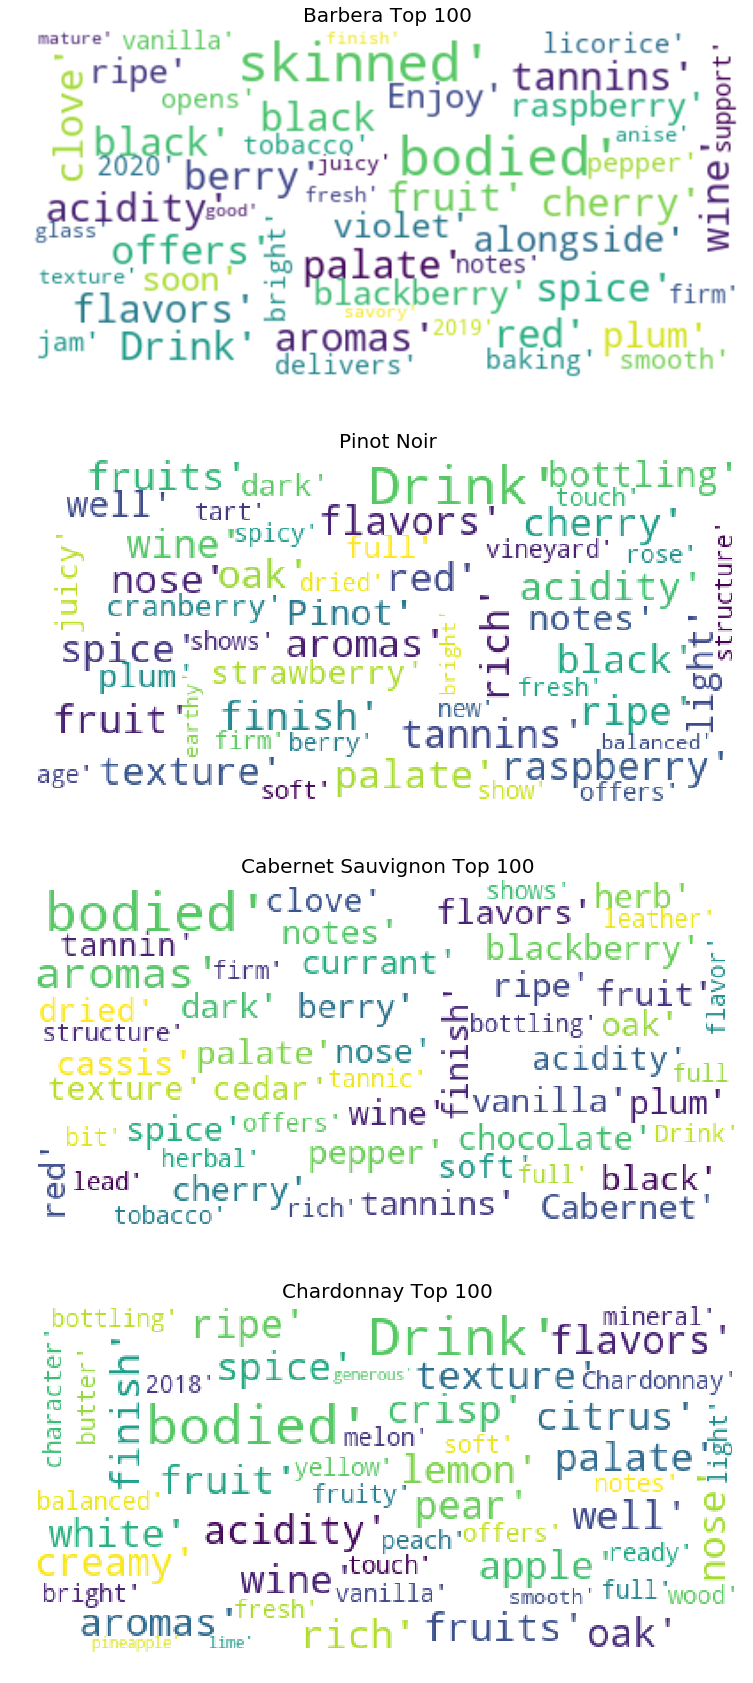

In [21]:
fig,axes = plt.subplots(4, 1, figsize=(30, 30))

ax = axes[0]
ax.imshow(generate_wordcloud(barbera100), interpolation="bilinear")
ax.axis('off')
ax.set_title("Barbera Top 100", fontsize=20)

ax = axes[1]
ax.imshow(generate_wordcloud(pinotnoir100))
ax.axis('off')
ax.set_title("Pinot Noir", fontsize=20)

ax = axes[2]
ax.imshow(generate_wordcloud(cabsauv100))
ax.axis('off')
ax.set_title("Cabernet Sauvignon Top 100", fontsize=20)

ax = axes[3]
ax.imshow(generate_wordcloud(chardonnay100))
ax.axis('off')
ax.set_title("Chardonnay Top 100", fontsize=20)

### tf-idf: Term Frequency, Inverse Document Frequency

We can set up our SKLearn vectorizer (e.g. the method that counts words against the TFIDF metric) to set a threshold for the minimum number of times a word/phrase appears in the corpus (min_df), and the phrase length, e.g. 2 or 3 word phrases (ngram_range). Playing with the ngram_range gives some interesting results about how wines are decribed in multiple word phrases! I tested at 2 and 3 word phrases.

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df = 10,
                            max_features=180000,
                            tokenizer=tokenize,
                            ngram_range=(1,3))

In [23]:
all_descriptions = data['description'].values
vz = vectorizer.fit_transform(list(all_descriptions))

Now we can get an ordered list of the lowest (e.g. most generic) vs. highest (most unique) words/phrases used to describe the wine. 

In [24]:
#Create a dictionary mapping the tokens to their TF-IDF values
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame().from_dict(dict(tfidf), orient='index')
tfidf.columns=['tfidf']

In [25]:
#Ascending tfidf score
tfidf.sort_values(by=['tfidf'], ascending=True).head(10)

,tfidf
wine,1.665765
flavors,1.816276
palate,1.887890
aromas,1.984558
drink,2.071456
fruit,2.128522
acidity,2.138640
tannins,2.217452
finish,2.272102
ripe,2.446376


The snipped below will return the 100 most unique 3 word phrases used to describe wine. Some of them won't make any sense because we removed all punctuation, so the combination might just be unique because it occurred at the end then the beginning of two sentences (perhaps even with stop-words in between), but some of them are interesting!

In [26]:
#Descending tfidf score
tfidf.sort_values(by=['tfidf'], ascending=False).head(100)

,tfidf
lead broad,8.066777
polished tannins fresh,8.066777
plum blueberry,8.066777
plumes,8.066777
pluot,8.066777
plush palate,8.066777
browned butter,8.066777
broad aromas,8.066777
pomegranate flavors,8.066777
plenty spice,8.066777


### t-SNE: t-Distributed Stochastic Neighbor Embedding

We can use t-SNE to reduce our high dimensionality dataset. This will essentially allow us to take all of our points and 'project' them to a lower dimensional space, in this case a 2D plane. The algorithm by which this is done isn't incredibly important, but it basically clusters words that appear near each other, or that appear near words that appear near it (2-degrees removed), etc. There's probabilistic distributions involved...

This can also take a long time to run, so we have to be careful! We'll start by taking a sample of the data.

In [27]:
#Get descending list of most common wine varietals in review dataset
topvarietals = data.copy()
top_sz = 19 # We'll take this many most common varieties
topvarietals = topvarietals.variety.value_counts(ascending=False)[:top_sz].reset_index()
topvarietals.columns = ['variety', 'count']
topvarietals.head(50)

,variety,count
0,Pinot Noir,1762
1,Chardonnay,1212
2,Bordeaux-style Red Blend,986
3,Red Blend,933
4,Cabernet Sauvignon,721
5,Riesling,636
6,Sparkling Blend,418
7,Sauvignon Blanc,364
8,Gamay,363
9,Syrah,326


In [28]:
#produce dataframe of only the 50 most common varieties to simplify visualization
reviews_topvarietals = data.copy()
reviews_topvarietals = reviews_topvarietals[reviews_topvarietals['variety'].isin(topvarietals.variety)]
reviews_topvarietals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9534 entries, 0 to 12894
Data columns (total 14 columns):
country                  9534 non-null object
description              9534 non-null object
designation              7009 non-null object
points                   9534 non-null int32
price                    9002 non-null float32
province                 9534 non-null object
region_1                 8075 non-null object
region_2                 3835 non-null object
taster_name              9534 non-null object
taster_twitter_handle    9027 non-null object
title                    9534 non-null object
variety                  9534 non-null object
winery                   9534 non-null object
tokens                   9534 non-null object
dtypes: float32(1), int32(1), object(12)
memory usage: 1.0+ MB


In [29]:
#Make a copy of our data (just in case :), then take a sample)
trn = reviews_topvarietals.copy()
sample_sz = 1000
trn_sample = trn.sample(n=sample_sz)
#Apply our previously defined tfidfVectorizer to our sample.
vz_sample = vectorizer.fit_transform(list(trn_sample['description']))

In [30]:
#We first reduce the dimension of our data using Singular Value Decomposition (SVD)
from sklearn.decomposition import TruncatedSVD
n_comp=30
svd = TruncatedSVD(n_components=n_comp, random_state=42)
svd_tfidf = svd.fit_transform(vz_sample)

In [31]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=42, n_iter=500)

In [32]:
tsne_tfidf = tsne_model.fit_transform(svd_tfidf)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.067s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.174387
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.076462
[t-SNE] Error after 500 iterations: 1.256855


In [33]:
output_notebook()
plot_tfidf = bp.figure(plot_width=900, plot_height=900, 
                       title="tf-idf clustering of wine descriptions",
                       tools="pan, wheel_zoom, box_zoom,reset,hover,previewsave",
                       x_axis_type=None, y_axis_type=None, min_border=1)

Loading BokehJS ...

In [34]:
trn_sample.reset_index(inplace=True, drop=True)

In [35]:
tfidf_df=pd.DataFrame(tsne_tfidf, columns=['x','y'])
tfidf_df['description'] = trn_sample['description']
tfidf_df['variety'] = trn_sample['variety']

In [36]:
#Confirm that we only have a limited number of varieties to view
print(len(tfidf_df['variety'].unique()))

19


In [37]:
palette = d3['Category20'][len(tfidf_df['variety'].unique())+1]
labels = ['Pinot Noir','Chardonnay','Bordeaux-style Red Blend','Red Blend','Cabernet Sauvignon','Riesling','Sparkling Blend','Sauvignon Blanc','Gamay','Syrah','NebbioloPortuguese Red','Merlot','Glera','Rosé','White Blend','Zinfandel','Malbec','Rhône-style Red Blend']

In [38]:
#Define pallette and color mapping. We'll color the dots by the wine variety
color_mapper = bmo.CategoricalColorMapper(factors=labels, palette=palette)

plot_tfidf.scatter(x='x',y='y',
                   source=tfidf_df, alpha=0.7, 
                   color={'field': 'variety', 'transform': color_mapper},
                   line_width=1)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"Description": "@description", "Variety": "@variety"}
show(plot_tfidf)

Another interesting way to view this data: although its not perfect, we can begin to see clusters of different varietals purely based on the words used to describe them! One application of this method might be to make predictions about the varietal of a wine purely based on the words used to describe the taste. Imagine: you speak that you taste cherry, pepper, hints of leather and smoke, and an algorithm is able to come up with the 3 most likely wines you might be tastings!